# Comparison of the models
@LuiseJedlitschka @davmar01

We decided to train the following models: MLP, Random Forest, XGBoost.
We trained them on stratified 80/20 split and on leave-one-group-out splits (one dataset as testset each).
These trained models are being compared here in their accuracy using confusion matrices and metrics (precision, recall, f1).

In [10]:
import joblib
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Suppress unnecessary warnings
import warnings
from sklearn.exceptions import InconsistentVersionWarning

warnings.filterwarnings("ignore", category=InconsistentVersionWarning)


In [11]:
# === Setup for MLP ===
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.out = nn.Linear(64, num_classes)
        self.drop = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.drop(F.relu(self.fc3(x)))
        return self.out(x)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

=== Split 0 ===


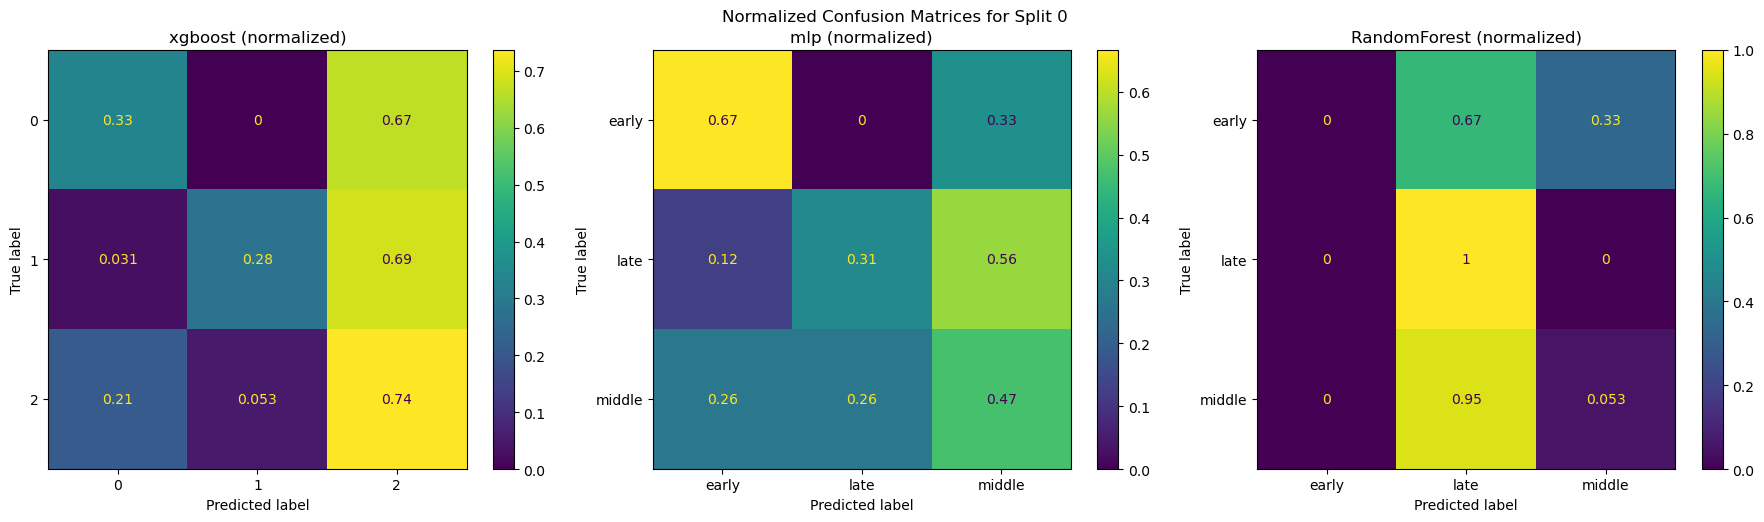

,Split,Model,Accuracy,Precision,Recall,F1
0,0,xgboost,0.444444,0.672222,0.444444,0.439153
1,0,mlp,0.388889,0.518258,0.388889,0.402792
2,0,RandomForest,0.611111,0.540598,0.611111,0.485009


=== Split 1 ===


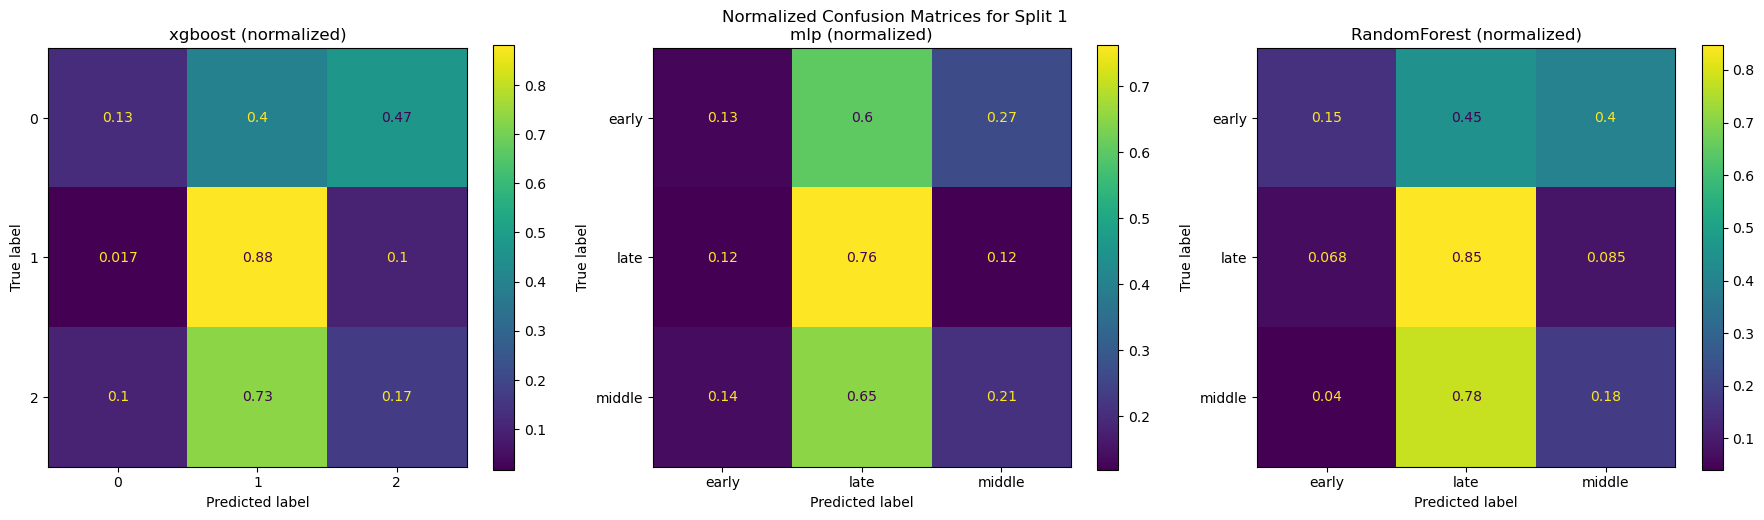

,Split,Model,Accuracy,Precision,Recall,F1
0,1,xgboost,0.333333,0.359253,0.333333,0.276570
1,1,mlp,0.320675,0.358351,0.320675,0.283051
2,1,RandomForest,0.337553,0.414479,0.337553,0.291372


=== Split 2 ===


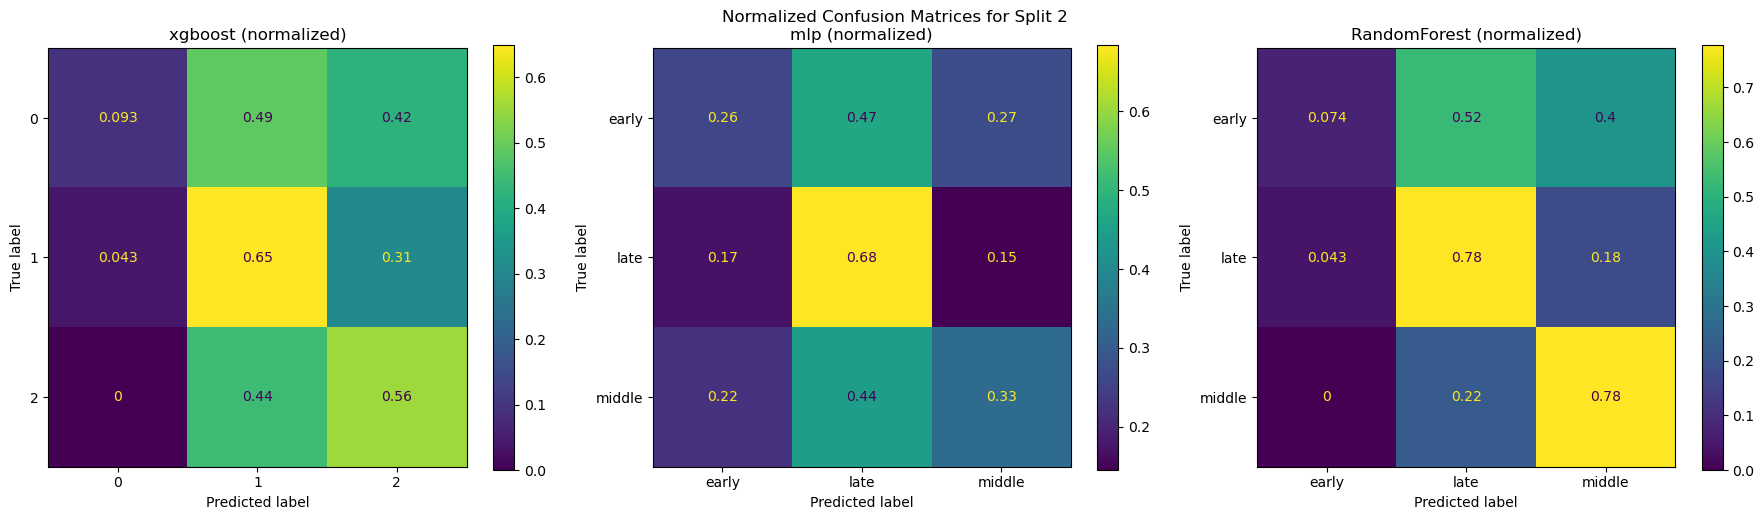

,Split,Model,Accuracy,Precision,Recall,F1
0,2,xgboost,0.333333,0.617491,0.333333,0.319100
1,2,mlp,0.434028,0.573730,0.434028,0.446296
2,2,RandomForest,0.381944,0.607101,0.381944,0.330344


=== Split 3 ===


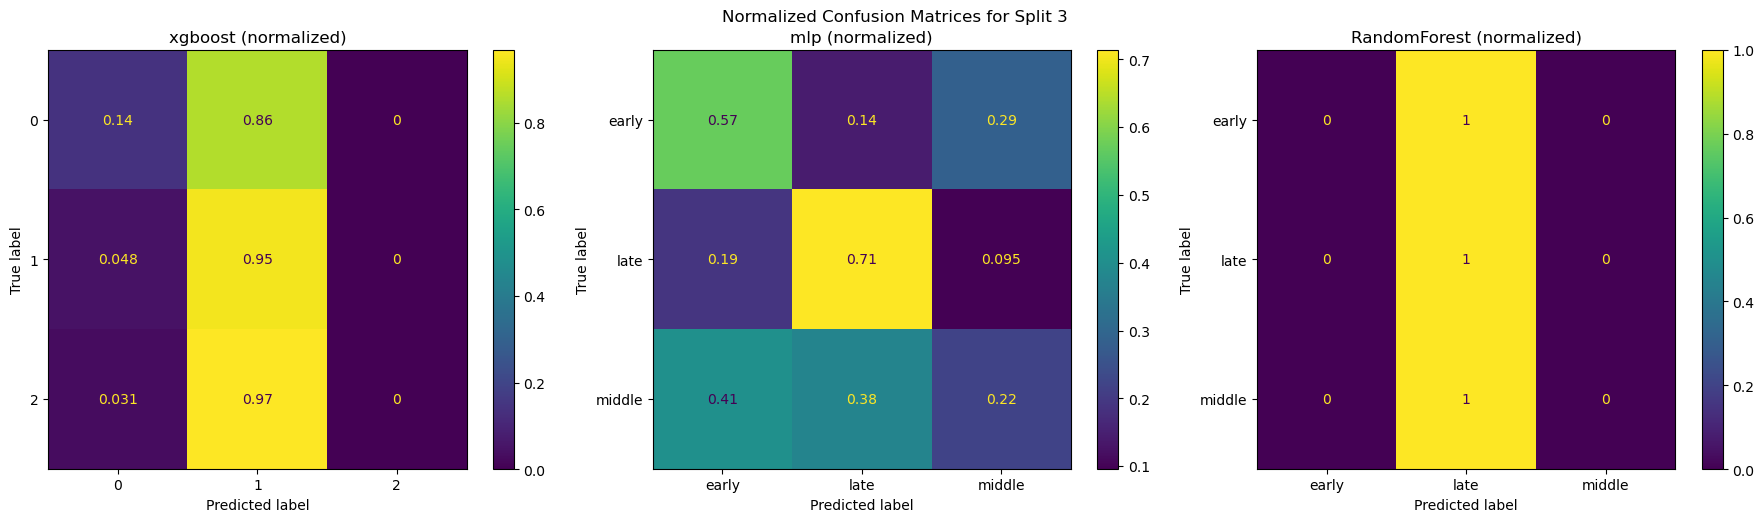

,Split,Model,Accuracy,Precision,Recall,F1
0,3,xgboost,0.350000,0.161696,0.350000,0.202821
1,3,mlp,0.433333,0.549116,0.433333,0.421262
2,3,RandomForest,0.350000,0.122500,0.350000,0.181481


=== Split 4 ===


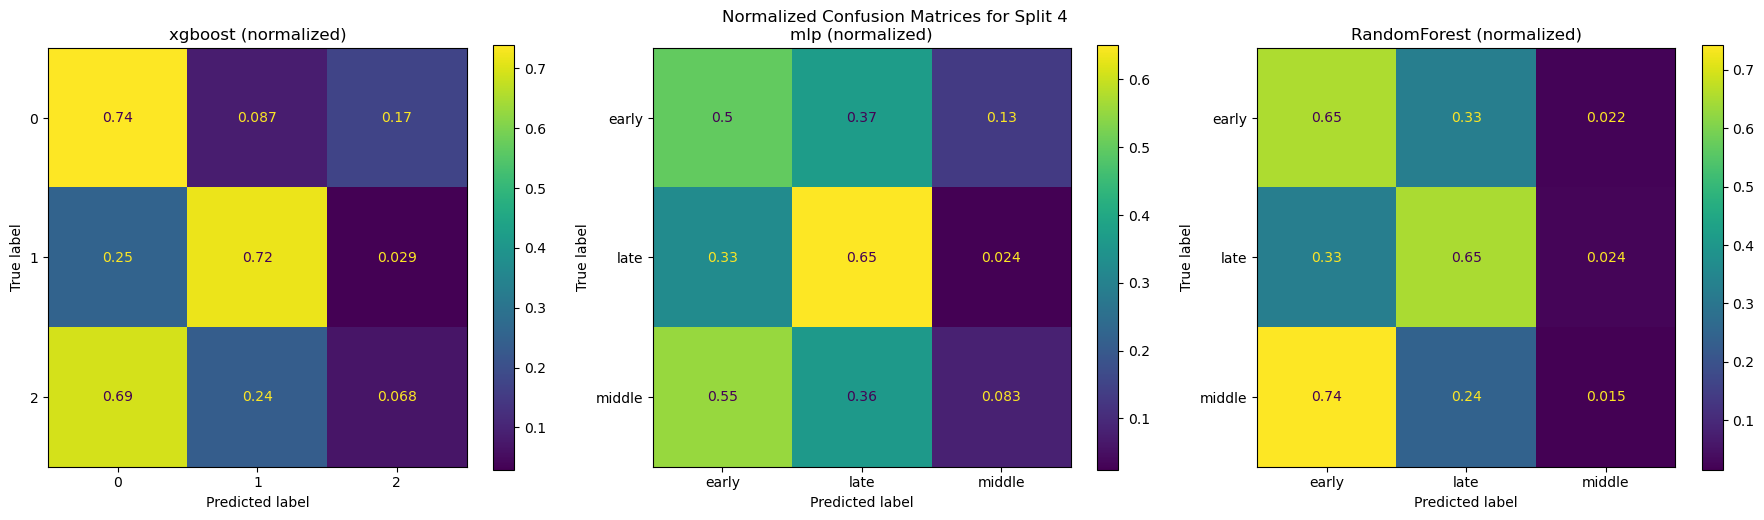

,Split,Model,Accuracy,Precision,Recall,F1
0,4,xgboost,0.429501,0.573175,0.429501,0.408172
1,4,mlp,0.381779,0.552926,0.381779,0.365399
2,4,RandomForest,0.366594,0.467630,0.366594,0.333396


=== Split 5 ===


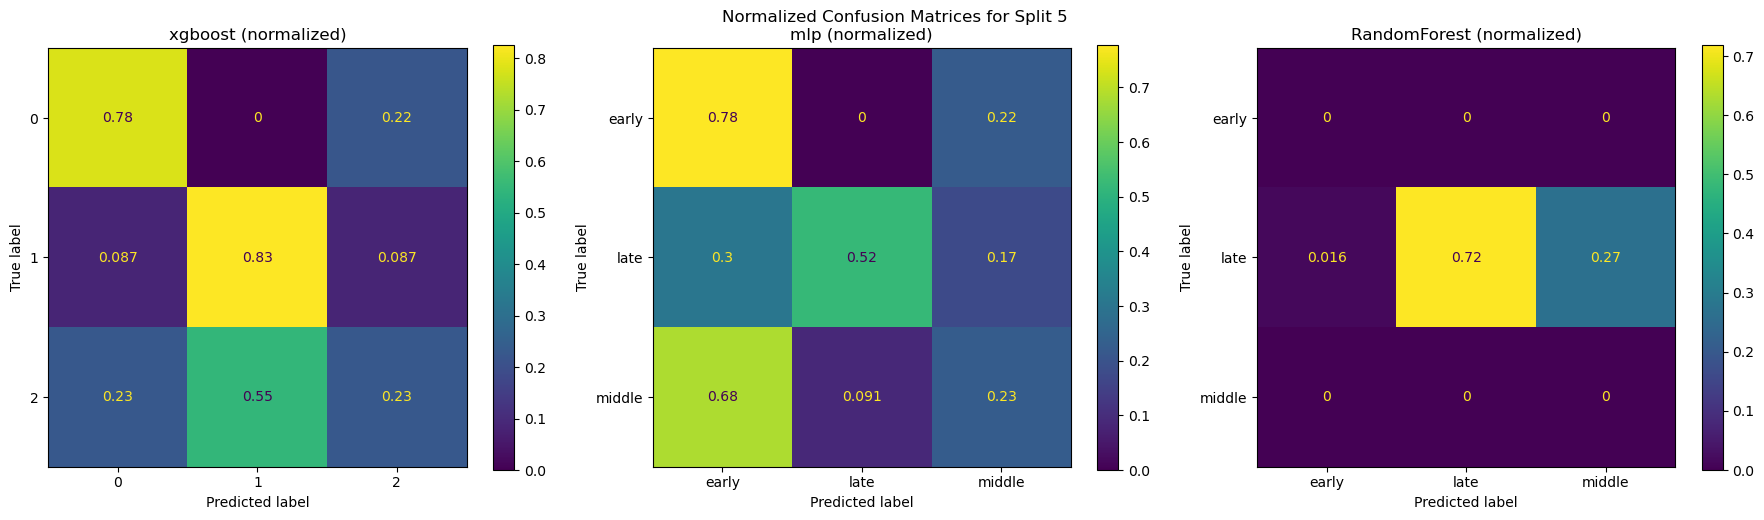

,Split,Model,Accuracy,Precision,Recall,F1
0,5,xgboost,0.574074,0.570722,0.574074,0.532597
1,5,mlp,0.444444,0.590494,0.444444,0.461137
2,5,RandomForest,0.718750,1.000000,0.718750,0.836364


=== Split 6 ===


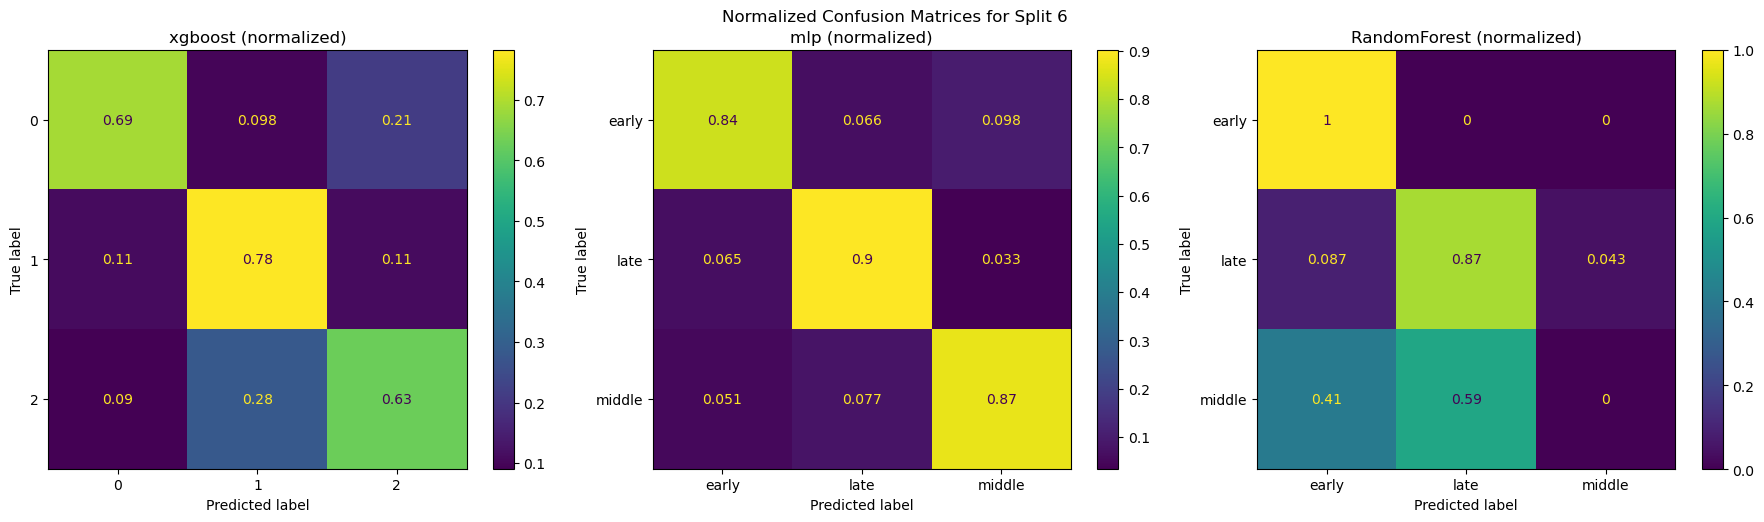

,Split,Model,Accuracy,Precision,Recall,F1
0,6,xgboost,0.705628,0.704533,0.705628,0.704156
1,6,mlp,0.874459,0.874418,0.874459,0.874416
2,6,RandomForest,0.537037,0.333137,0.537037,0.407681



Summary for XGBOOST


,Split,Model,Accuracy,Precision,Recall,F1
0,0,xgboost,0.444444,0.672222,0.444444,0.439153
1,1,xgboost,0.333333,0.359253,0.333333,0.276570
2,2,xgboost,0.333333,0.617491,0.333333,0.319100
3,3,xgboost,0.350000,0.161696,0.350000,0.202821
4,4,xgboost,0.429501,0.573175,0.429501,0.408172
5,5,xgboost,0.574074,0.570722,0.574074,0.532597
6,6,xgboost,0.705628,0.704533,0.705628,0.704156



Summary for MLP


,Split,Model,Accuracy,Precision,Recall,F1
0,0,mlp,0.388889,0.518258,0.388889,0.402792
1,1,mlp,0.320675,0.358351,0.320675,0.283051
2,2,mlp,0.434028,0.573730,0.434028,0.446296
3,3,mlp,0.433333,0.549116,0.433333,0.421262
4,4,mlp,0.381779,0.552926,0.381779,0.365399
5,5,mlp,0.444444,0.590494,0.444444,0.461137
6,6,mlp,0.874459,0.874418,0.874459,0.874416



Summary for RANDOMFOREST


,Split,Model,Accuracy,Precision,Recall,F1
0,0,RandomForest,0.611111,0.540598,0.611111,0.485009
1,1,RandomForest,0.337553,0.414479,0.337553,0.291372
2,2,RandomForest,0.381944,0.607101,0.381944,0.330344
3,3,RandomForest,0.350000,0.122500,0.350000,0.181481
4,4,RandomForest,0.366594,0.467630,0.366594,0.333396
5,5,RandomForest,0.718750,1.000000,0.718750,0.836364
6,6,RandomForest,0.537037,0.333137,0.537037,0.407681


In [12]:
# Model evaluation

model_names = ["xgboost", "mlp", "RandomForest"]
splits = range(7)
all_results = []

for split_number in splits:
    print(f"=== Split {split_number} ===")
    fig, axes = plt.subplots(1, len(model_names), figsize=(6 * len(model_names), 5))
    metrics_list = []

    for i, name in enumerate(model_names):
        model_dir = f"../data/{name}"
        model_file = f"model_split_{split_number}"
        data_file = f"split_{split_number}_data.pkl"
        model_path = os.path.join(model_dir, model_file)
        data_path = os.path.join(model_dir, data_file)

        try:
            # Load test data and label encoder
            with open(data_path, "rb") as f:
                _, _, X_test, y_test, le, feature_cols = pickle.load(f)

            # === Handle PyTorch MLP ===
            if name == "mlp":
                model = MLP(input_dim=X_test.shape[1], num_classes=len(le.classes_)).to(DEVICE)
                model.load_state_dict(torch.load(model_path + ".pt", map_location=DEVICE))
                model.eval()
                with torch.no_grad():
                    X_tensor = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
                    y_pred = model(X_tensor).argmax(dim=1).cpu().numpy()
            else:
                # === Handle sklearn-based models ===
                model = joblib.load(model_path + ".joblib")
                y_pred = model.predict(X_test)

            # === Plot confusion matrix ===
            ConfusionMatrixDisplay.from_predictions(
                y_test,
                y_pred,
                display_labels=le.classes_,
                normalize="true",
                ax=axes[i]
            )
            axes[i].set_title(f"{name} (normalized)")

            # === Compute metrics ===
            metrics = {
                "Split": split_number,
                "Model": name,
                "Accuracy": accuracy_score(y_test, y_pred),
                "Precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
                "Recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
                "F1": f1_score(y_test, y_pred, average="weighted", zero_division=0),
            }

            # Prevent duplicates
            if not any(r["Split"] == metrics["Split"] and r["Model"] == metrics["Model"] for r in all_results):
                metrics_list.append(metrics)

        except FileNotFoundError:
            print(f"Model or data missing for {name} (Split {split_number})")
            axes[i].set_visible(False)
            continue

    plt.suptitle(f"Normalized Confusion Matrices for Split {split_number}")
    plt.tight_layout()
    plt.show()

    if metrics_list:
        df_metrics = pd.DataFrame(metrics_list)
        display(df_metrics)
        all_results.extend(metrics_list)
    else:
        print("No models evaluated for this split.")

# === Show final results across all splits ===
df_all = pd.DataFrame(all_results)

# Display one summary table per model
for model in df_all["Model"].unique():
    print(f"\nSummary for {model.upper()}")
    df_model = df_all[df_all["Model"] == model].reset_index(drop=True)
    display(df_model)
